## Multitaper Spectral Estimator Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_palette("husl", 8)

import scipy
from scipy import signal
from stingray import Multitaper, Powerspectrum, Lightcurve

/home/dhruv/repos/stingray/stingray/largememory.py:25: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  warnings.warn(


### Creating a light curve  
---
Lets create a `Lightcurve` sampled from an autoregressive process of order 4 that has been extensively used in literature

/home/dhruv/repos/stingray/stingray/utils.py:126: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


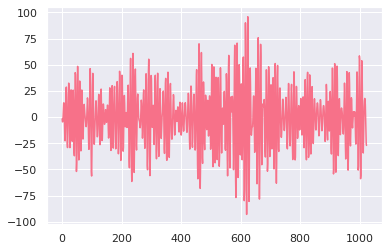

In [2]:
np.random.seed(100)
coeff = np.array([2.7607, -3.8106, 2.6535, -0.9238]) # The 4 coefficients for the AR(4) process
ar4 = np.r_[1, -coeff] # For use with scipy.signal
N = 1024

freq_analytical, h = signal.freqz(b=1.0, a=ar4, worN=N, fs=1) # True PSD of AR(4)
psd_analytical = (h * h.conj()).real

data = signal.lfilter([1.0], ar4, np.random.normal(0, 1, N)) # 1000 AR(4) data samples.

times = np.arange(N)

err = np.zeros_like(data) + (np.sqrt(np.abs(np.mean(data))) / data.max())

lc_ar4 = Lightcurve(time=times, counts=data, err_dist='gauss', err=err)
lc_ar4.plot()

# Utility function to convert power to decibels
def dB(power):
    return 10*np.log10(power)

### Creating a `Multitaper` object
Before getting into the details of how the multitaper estimator works, lets have a look at how to use this functionality

#### Pass the `Lightcurve` object to the `Multitaper` constructor
##### Other (optional) parameters that can be set at instantiation are:
(Given here for completness, feel free to skip as they are later showcased)

`norm`: {`leahy` | `frac` | `abs` | `none` }, optional, default ``frac``  
    The normaliation of the power spectrum to be used. Options are
    ``leahy``, ``frac``, ``abs`` and ``none``, default is ``frac``. 
        
`NW`: float, optional, default ``4``    
    The normalized half-bandwidth of the data tapers, indicating a
    multiple of the fundamental frequency of the DFT (Fs/N).
    Common choices are n/2, for n >= 4.
    
`adaptive`: boolean, optional, default ``False``  
    Use an adaptive weighting routine to combine the PSD estimates of
    different tapers.  
    
`jackknife`: boolean, optional, default ``True``  
    Use the jackknife method to make an estimate of the PSD variance
    at each point.  
    
`low_bias`: boolean, optional, default ``True``  
    Rather than use 2NW tapers, only use the tapers that have better than
    90% spectral concentration within the bandwidth (still using
    a maximum of 2NW tapers)  
    
`lombscargle`: boolean, optional, default ``False``  
    Whether to use the Lomb (1976) Scargle (1982) periodogram when
    calculating the Multitaper spectral estimate. Highly recommended for
    unevenly sampled time-series. Adaptive weighting and jack-knife
    estimated variance are yet not supported.  

In [3]:
mtp = Multitaper(lc_ar4, adaptive=True, norm="abs")
print(mtp)

/home/dhruv/repos/stingray/stingray/utils.py:126: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Using 7 DPSS windows for multitaper spectrum estimator


/home/dhruv/repos/stingray/stingray/utils.py:126: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


#### The results

Text(0.5, 1.0, 'AR(4) Spectrum')

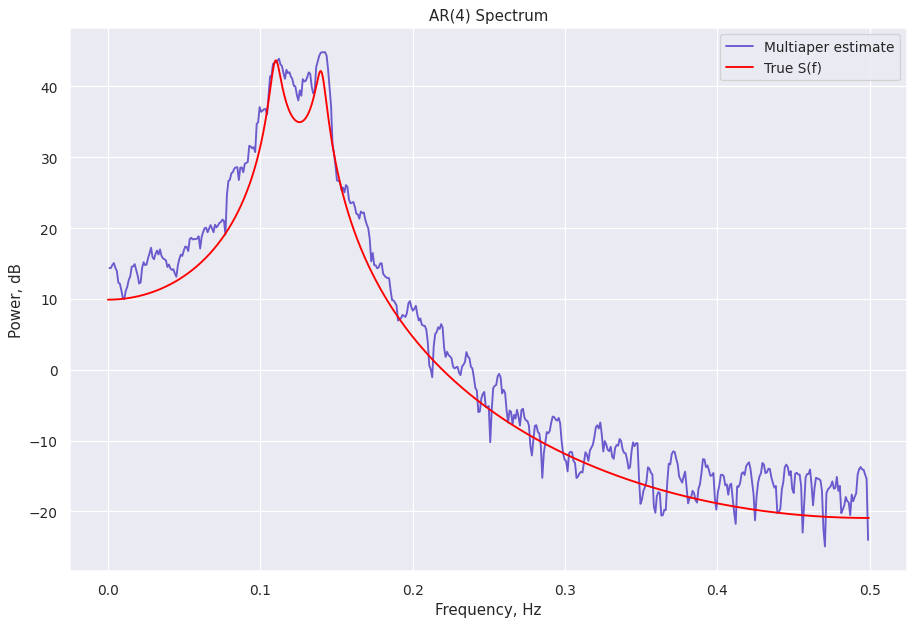

In [4]:
fig = plt.figure(figsize=(12, 8), dpi=90)
plt.plot(mtp.freq, dB(mtp.multitaper_norm_power), color="slateblue", label="Multiaper estimate")
plt.plot(freq_analytical, dB(psd_analytical), color="red", label="True S(f)")
plt.legend()
plt.ylabel("Power, dB")
plt.xlabel("Frequency, Hz")
plt.title("AR(4) Spectrum")

#### While it seems decent, lets compare with `Powerspectrum`

In [5]:
ps = Powerspectrum(lc_ar4, norm="abs")

/home/dhruv/repos/stingray/stingray/utils.py:126: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/dhruv/repos/stingray/stingray/utils.py:126: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Text(0.5, 1.0, 'AR(4) Spectrum')

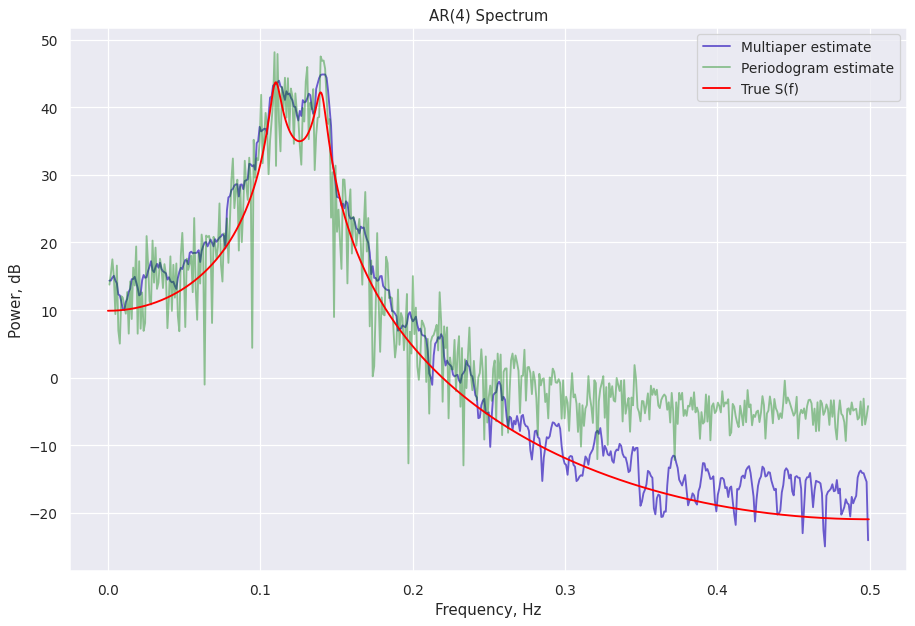

In [6]:
fig = plt.figure(figsize=(12, 8), dpi=90)
plt.plot(mtp.freq, dB(mtp.multitaper_norm_power), color="slateblue", label="Multiaper estimate")
plt.plot(ps.freq, dB(ps.power), color="green", label="Periodogram estimate", alpha=0.4)
plt.plot(freq_analytical, dB(psd_analytical), color="red", label="True S(f)")
plt.legend()
plt.ylabel("Power, dB")
plt.xlabel("Frequency, Hz")
plt.title("AR(4) Spectrum")

##### As can be seen, there is improvement in both the variance and the bias.

### Attributes of the Multitaper object
``norm``: {``leahy`` | ``frac`` | ``abs`` | ``none`` }
        the normalization of the power spectrun

``freq``: The array of mid-bin frequencies that the Fourier transform samples

``power``: The array of normalized squared absolute values of Fourier
amplitudes

``unnorm_power``: The array of unnormalized values of Fourier amplitudes

``multitaper_norm_power``:The array of normalized values of Fourier amplitudes, normalized
    according to the scheme followed in nitime, that is, by the length and
    the sampling frequency.

``power_err``: The uncertainties of ``power``.
    An approximation for each bin given by ``power_err = power/sqrt(m)``.
    Where ``m`` is the number of power averaged in each bin (by frequency
    binning, or averaging power spectrum). Note that for a single
    realization (``m=1``) the error is equal to the power.

``df``: The frequency resolution

``m``: The number of averaged powers in each bin

``n``: The number of data points in the light curve

``nphots``: The total number of photons in the light curve

``jk_var_deg_freedom``: Array differs depending on whether
the jackknife was used. It is either
- The jackknife estimated variance of the log-psd, OR
- The degrees of freedom in a chi2 model of how the estimated
  PSD is distributed about the true log-PSD (this is either
  2\*floor(2\*NW), or calculated from adaptive weights)

### A look at the values contained in these attributes.

In [7]:
print(mtp)
print("norm: ", mtp.norm, type(mtp.norm))
print("power.shape: ", mtp.power.shape, type(mtp.power))
print("unnorm_power.shape: ", mtp.unnorm_power.shape, type(mtp.unnorm_power))
print("multitaper_norm_power.shape: ", mtp.multitaper_norm_power.shape, type(mtp.multitaper_norm_power))
print("power_err.shape: ", mtp.power_err.shape, type(mtp.power_err))
print("df: ", mtp.df, type(mtp.df))
print("m: ", mtp.m, type(mtp.m))
print("n: ", mtp.n, type(mtp.n)) # Notice the length of PSDs is half that of the number of data points in the light curve, as the imaginary (complex) part is discarded.
print("nphots: ", mtp.nphots, type(mtp.nphots))
print("jk_var_deg_freedom.shape: ", mtp.jk_var_deg_freedom.shape, type(mtp.jk_var_deg_freedom))

norm:  abs <class 'str'>
power.shape:  (511,) <class 'numpy.ndarray'>
unnorm_power.shape:  (511,) <class 'numpy.ndarray'>
multitaper_norm_power.shape:  (511,) <class 'numpy.ndarray'>
power_err.shape:  (511,) <class 'numpy.ndarray'>
df:  0.0009765625 <class 'numpy.float64'>
m:  1 <class 'int'>
n:  1024 <class 'int'>
nphots:  -73.38213649959974 <class 'numpy.float64'>
jk_var_deg_freedom.shape:  (511,) <class 'numpy.ndarray'>


### A look at the different normalizations
The normalized S(f) estimates are stored in the `power` attribute can be accessed like `mtp.power` if the object name is `mtp`

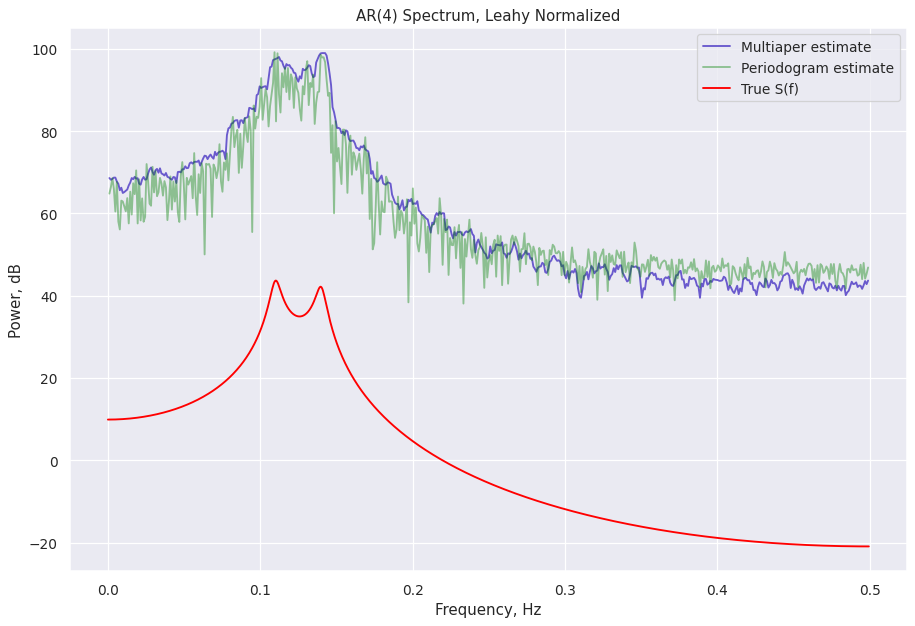

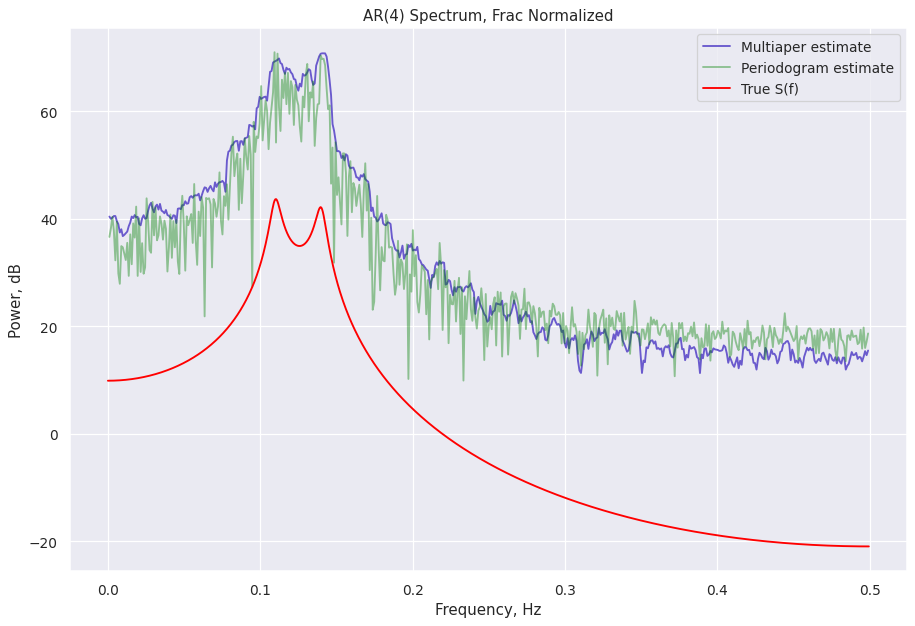

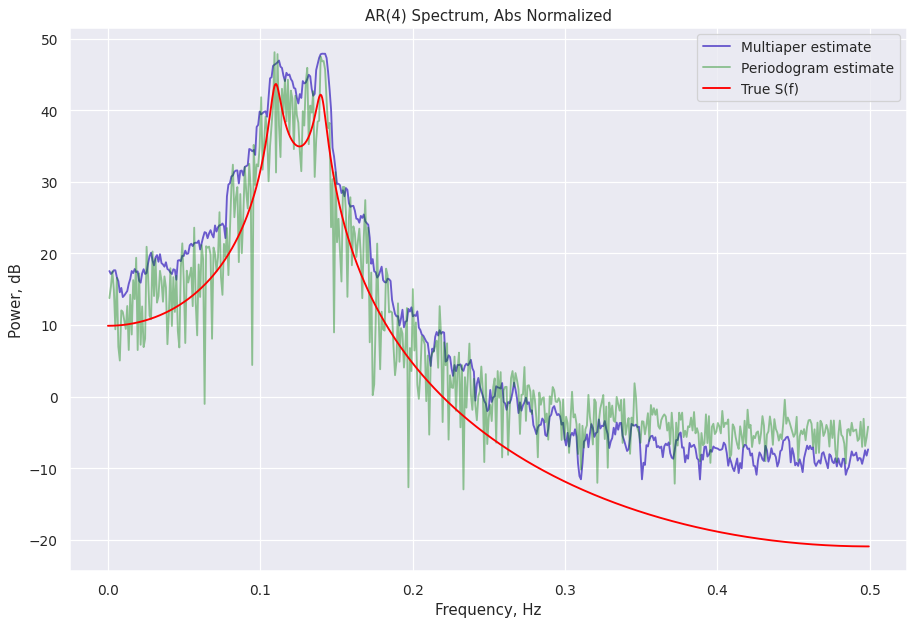

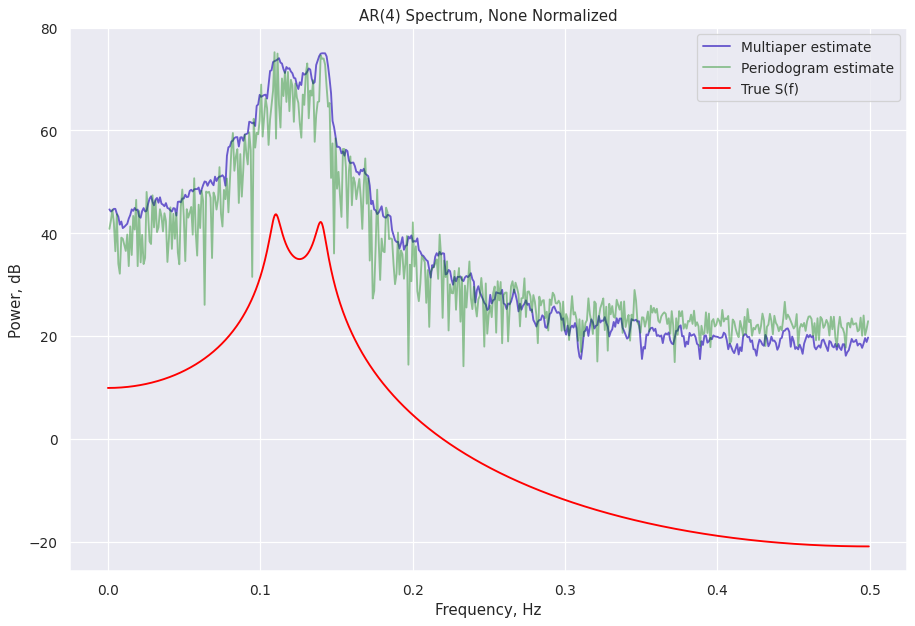

In [8]:
%%capture --no-display
norms = ["leahy", "frac", "abs", "none"]

for norm in norms:
    ps = Powerspectrum(lc_ar4, norm=norm)
    mtp = Multitaper(lc_ar4, norm=norm, adaptive=False) # adaptive=False does not calculate adaptive weights to reduce bias, helps see the normalization similarities better
    fig = plt.figure(figsize=(12, 8), dpi=90)
    plt.plot(mtp.freq, dB(mtp.power), color="slateblue", label="Multiaper estimate")
    plt.plot(ps.freq, dB(ps.power), color="green", label="Periodogram estimate", alpha=0.4)
    plt.plot(freq_analytical, dB(psd_analytical), color="red", label="True S(f)")
    plt.legend()
    plt.ylabel("Power, dB")
    plt.xlabel("Frequency, Hz")
    plt.title("AR(4) Spectrum, " + (norm + " normalized").title())

#### Other attributes with the S(f) estimates
If you look closely at the code for the first plot, you can see that we are plotting the `multitaper_norm_power` attribute instead of the `power` attribute of the `Multitaper` object, and that is because while the S(f) estimate in `power` is normalized according to your set `norm` type which is consistent with the rest of Stingray's norms, some implementations of the Multitapering method in different projects uses a different normalization, and hence for reproducibility and completeness, this is how the PSD is normalized in the `multitaper_norm_power` attribute.  

Another attribute containing the PSD is the `unnorm_power`, and as the name suggests, contains the unnormalized PSD.

### The Multitaper Periodogram  

Tapering a time series as a way of obtaining a spectral estimator with acceptable bias properties is an important concept. While tapering does reduce bias due to leakage, there is a price to pay in that the sample size is effectively reduced. The loss of information inherent in tapering can often be avoided either by prewhitening or by using Welch's overlapped segment averaging.

The multitaper periodogram is another approach to recover information lost due to tapering. This apporach was introduced by Thomson (1982) and involves the use of multiple orthogonal tapers.

In the multitaper method the data is windowed or tapered, but this method differs from the traditional methods in the tapers used, which are the most band-limited functions amongst those defined on a finite time domain, and also, these tapers are orthogonal, enabling us to average the _eigenspectrum_ (spectrum estimates from individual tapers) from more than one tapers to obtain a superior estimate in terms of noise. The resulting spectrum has low leakage, low variance, and retains information contained in the beginning and end of the time series. For more details on the multitaper periodogram, please have a look at the references.

##### Let's have a look at the individual tapers.

In [9]:
NW = 4 # normalized half-bandwidth = 4
Kmax = 8 # Number of tapers
dpss_tapers, eigvals = \
signal.windows.dpss(M=lc_ar4.n, NW=NW, Kmax=Kmax,
                    sym=False, return_ratios=True)

data_multitaper = lc_ar4.counts - np.mean(lc_ar4.counts)  # De-mean
data_multitaper = np.tile(data_multitaper, (len(eigvals), 1))

 # Data tapered with the dpss windows
data_multitaper = np.multiply(data_multitaper, dpss_tapers)

Plotted below are the first 8 tapers (on the left), and the corresponding tapered time series

Text(0.5, -0.02, 'DPSS tapers and product of these tapers and the AR(4) time series.\n    Note that, for K=0 in the top row, the extremes of the time series are severly\n    attenuated, but those, as K increases, portions of the extremes are accentuated.')

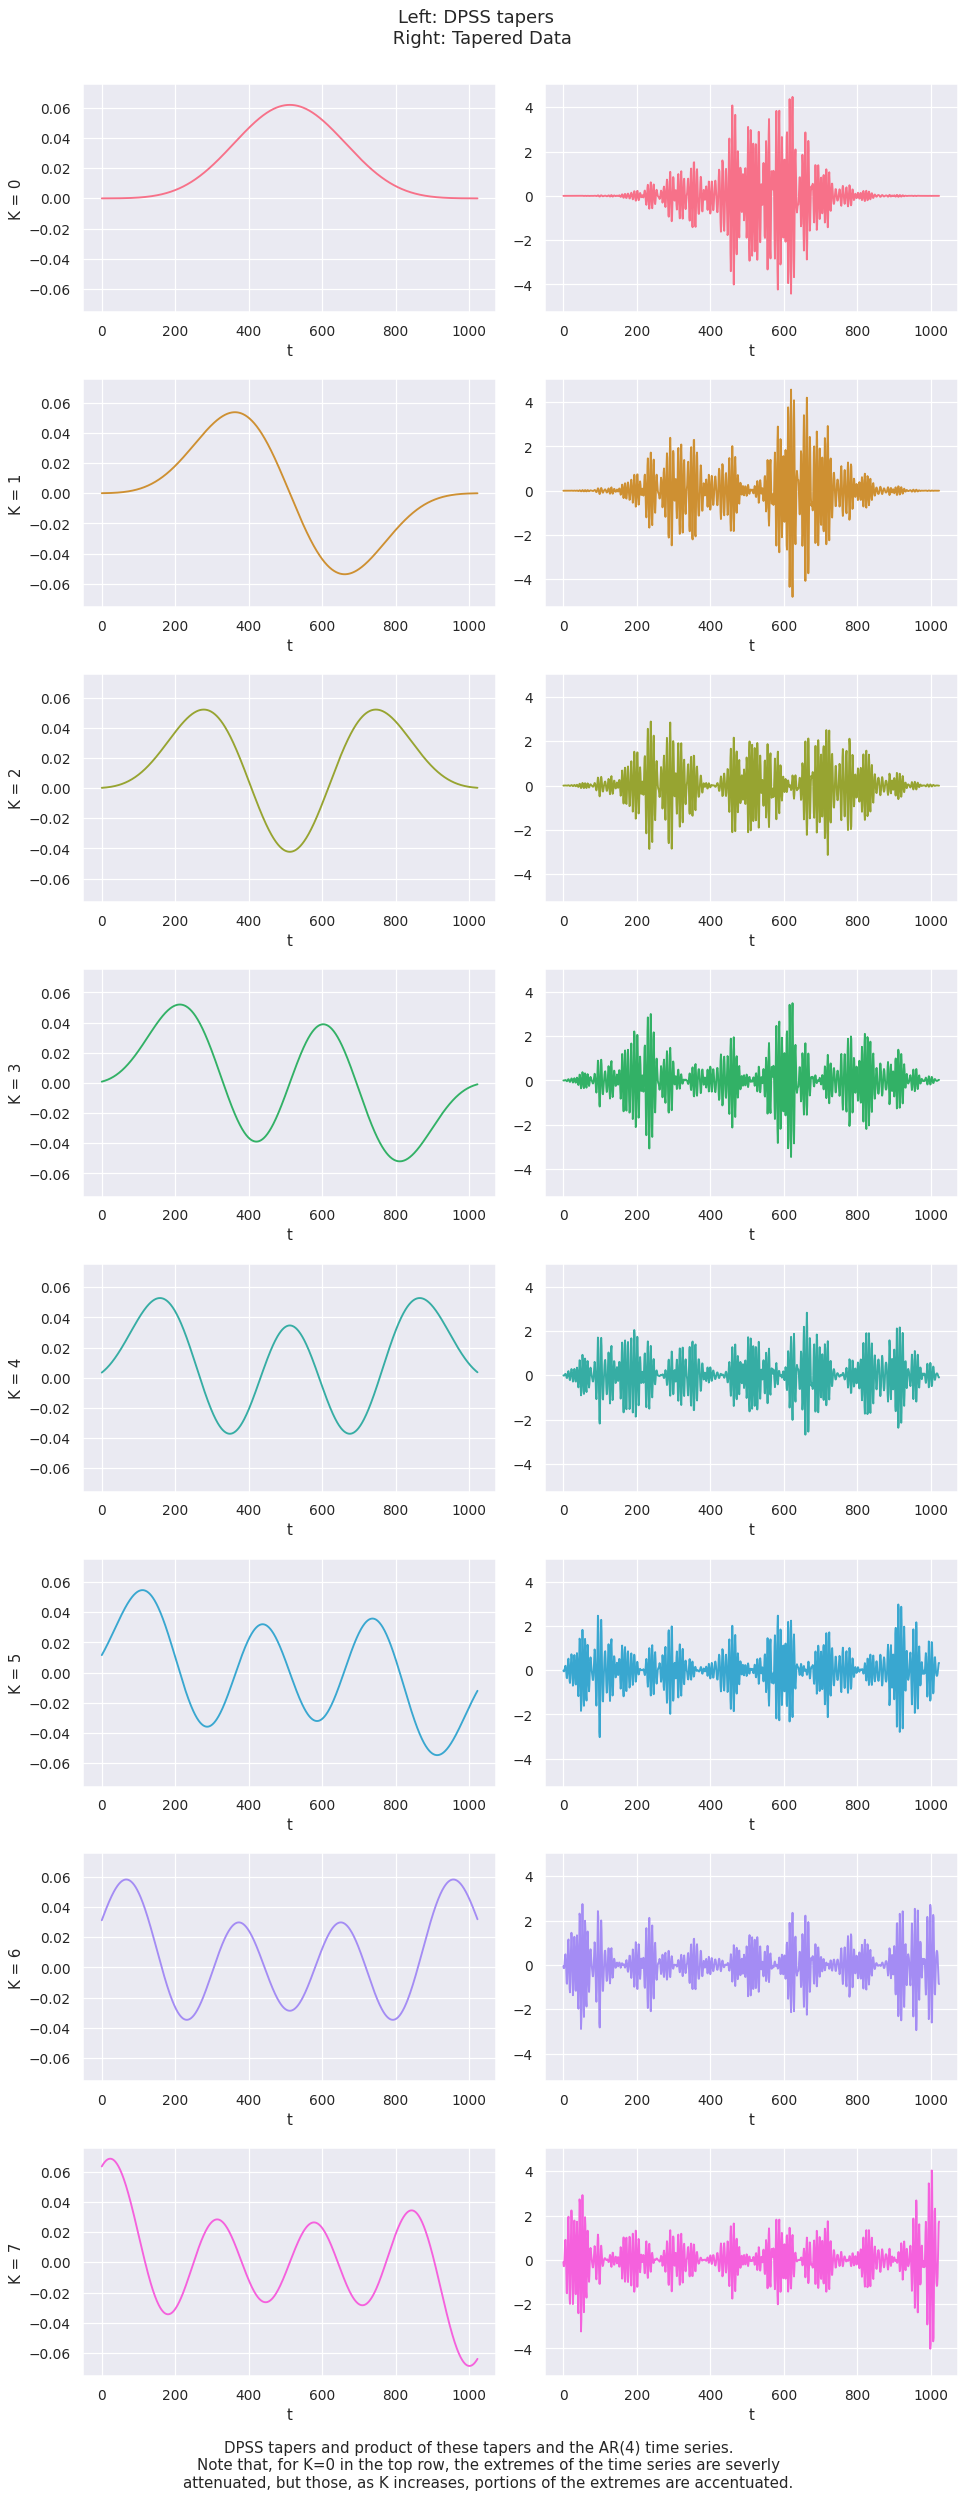

In [10]:
fig, axes = plt.subplots(8, 2, figsize=(11, 27), dpi=90, sharey='col')

idx = 0
palette = sns.color_palette("husl", 8)
for taper, tapered_data, axes_rows in zip(dpss_tapers, data_multitaper, axes):
    axes_rows[0].plot(lc_ar4.time, taper, color=palette[idx])
    axes_rows[0].set_ylabel(f"K = {idx}")
    axes_rows[0].set_xlabel("t")
    
    axes_rows[1].plot(lc_ar4.time, tapered_data, color=palette[idx])
    axes_rows[1].set_xlabel("t")
    
    idx += 1
fig.suptitle("Left: DPSS tapers \n Right: Tapered Data", y=1)
fig.tight_layout()
txt="DPSS tapers and product of these tapers and the AR(4) time series.\n\
    Note that, for K=0 in the top row, the extremes of the time series are severly\n\
    attenuated, but those, as K increases, portions of the extremes are accentuated."
fig.text(.5, -0.02, txt, ha='center')

#### Now let's see their frequency domain representations (here PSD)
We can have a good look at the leakage properties of these tapers (and the resulting time series) from their PSD representations.

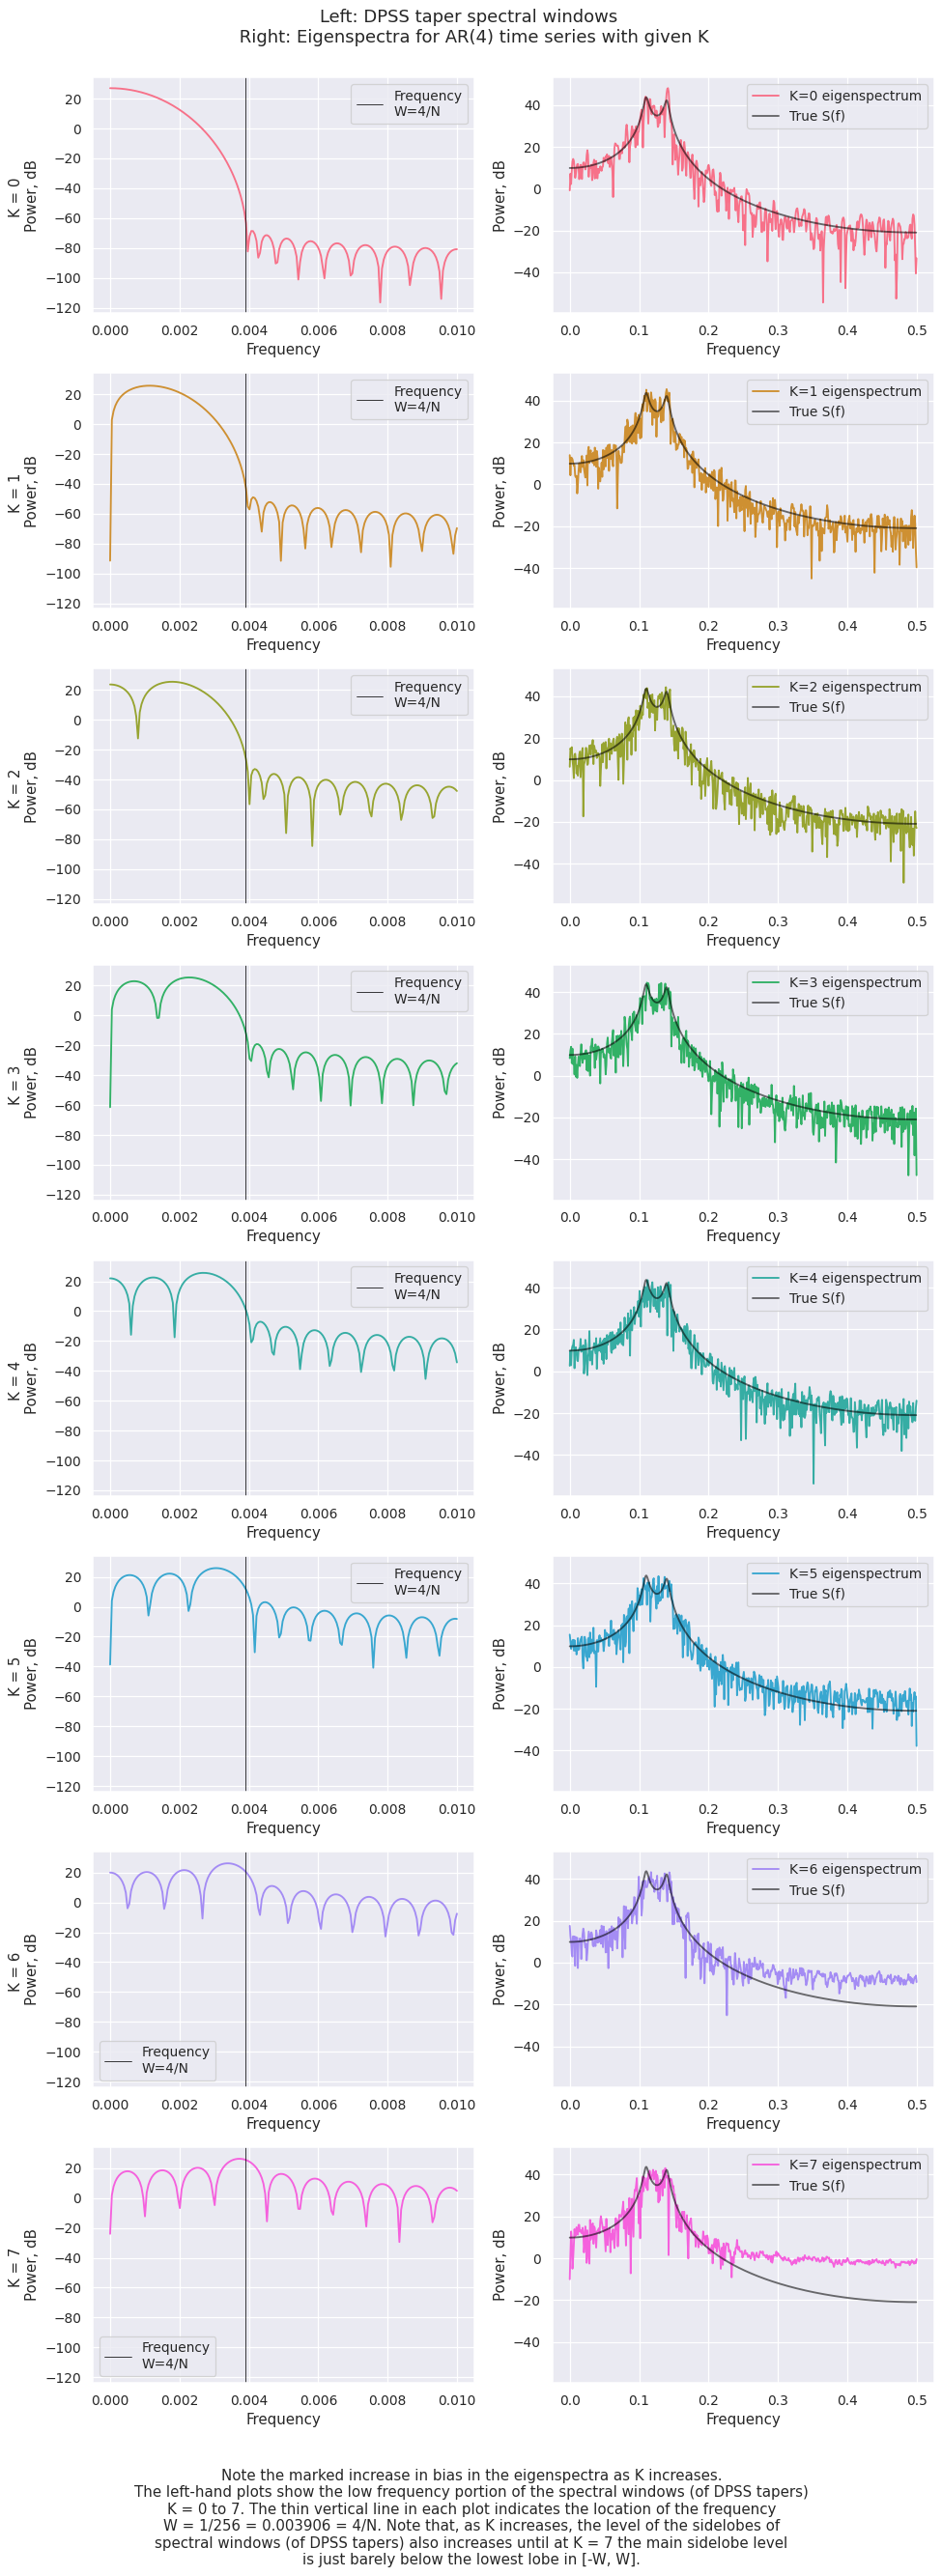

In [11]:
%%capture --no-display
fig, axes = plt.subplots(8, 2, figsize=(11, 28), dpi=90, sharey='col')

idx = 0
palette = sns.color_palette("husl", 8)

freq = scipy.fft.rfftfreq(lc_ar4.n, d=lc_ar4.dt)
for taper, tapered_data, axes_rows in zip(dpss_tapers, data_multitaper, axes):

    w, h = signal.freqz(taper, fs=1, worN=np.linspace(0, 0.01, 200))
    h = np.multiply(h, np.conj(h))
    axes_rows[0].plot(w, dB(h), color=palette[idx])
    axes_rows[0].axvline(x=NW/N, color="black", linewidth=0.6, label="Frequency\nW=4/N")
    axes_rows[0].set(
        ylabel=f"K = {idx} \nPower, dB",
        xlabel="Frequency"
    )
    axes_rows[0].legend()
    
    fft_tapered_data = scipy.fft.rfft(tapered_data)
    psd_tapered_data = np.multiply(fft_tapered_data, np.conj(fft_tapered_data))
    axes_rows[1].plot(freq, dB(psd_tapered_data), color=palette[idx], label=f"K={idx} eigenspectrum")
    axes_rows[1].plot(freq_analytical, dB(psd_analytical), color="black", alpha=0.56, label="True S(f)")
    axes_rows[1].set(
        xlabel="Frequency",
        ylabel="Power, dB"
    )
    axes_rows[1].legend()
    
    idx += 1
fig.suptitle("Left: DPSS taper spectral windows \n Right: Eigenspectra for AR(4) time series with given K", y=1)
text="Note the marked increase in bias in the eigenspectra as K increases.\n\
The left-hand plots show the low frequency portion of the spectral windows (of DPSS tapers)\n\
K = 0 to 7. The thin vertical line in each plot indicates the location of the frequency\n\
W = 1/256 = 0.003906 = 4/N. Note that, as K increases, the level of the sidelobes of\n\
spectral windows (of DPSS tapers) also increases until at K = 7 the main sidelobe level\n\
is just barely below the lowest lobe in [-W, W]."
fig.text(0.5, -0.05, text, ha="center")
fig.tight_layout()

### A look at `jk_var_deg_freedom`
This attribute differs depending on whether the jackknife was used. It is either
- The jackknife estimated variance of the log-psd, OR
- The degrees of freedom in a chi2 model of how the estimated PSD is distributed about the true log-PSD (this is either 2*floor(2*NW), or calculated from adaptive weights)  

We'll do a combination of the valid values for the `adaptive` and `jk_var_deg_freedom` and have a look at the results.

Text(0.5, -0.05, 'if jackknife == True:\njk_var_deg_freedom = jackknife estimated variance of the log-psd.\nelse:\njk_var_deg_freedom = degrees of freedom in a chi2\nmodel of how the estimated PSD is distributed about\nthe true log-PSD')

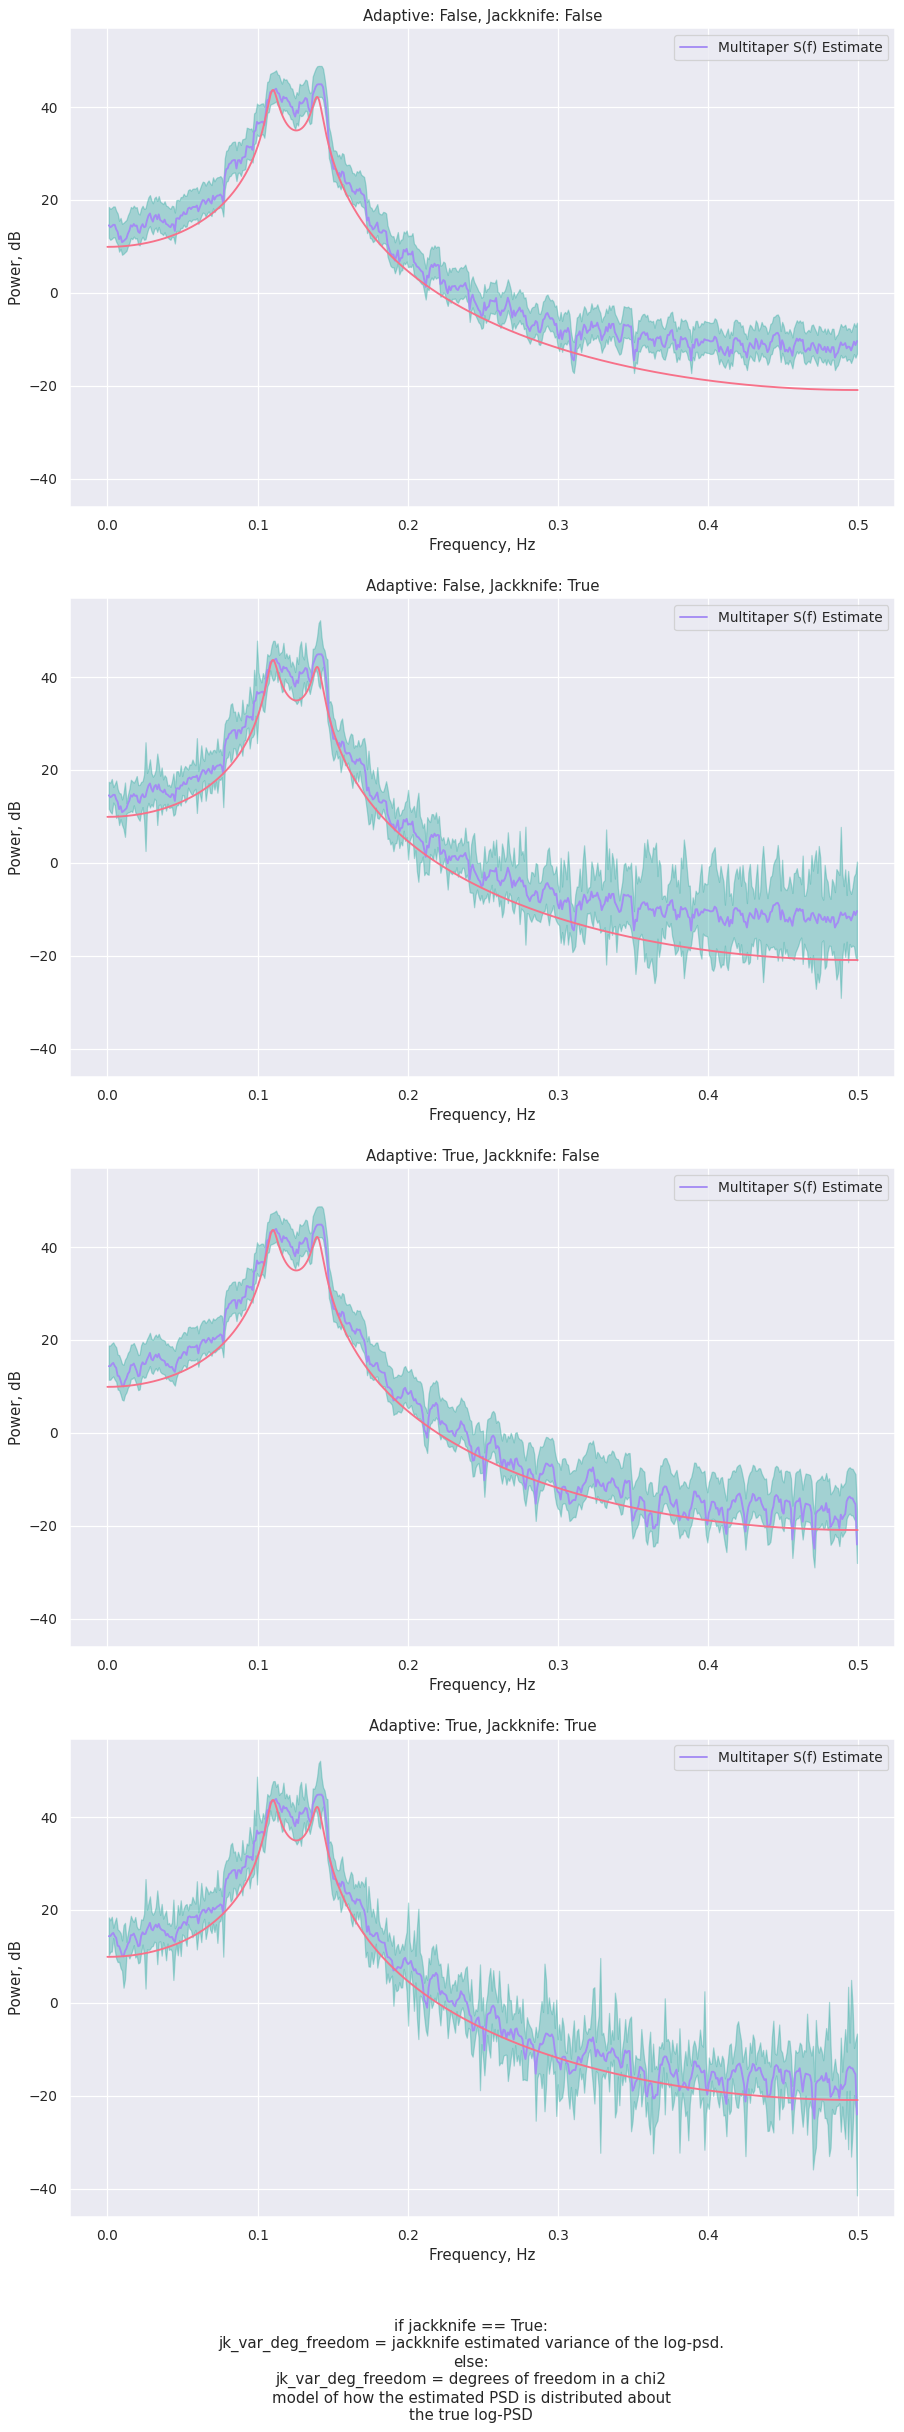

In [12]:
%%capture --no-display

# Setup utilities
import scipy.stats.distributions as dist

ln2db = dB(np.e) # Need this because we plot in decibles and Jack-knifing gives variance for log-psd


fig, axs = plt.subplots(4, 1, dpi=90, figsize=[11, 26], sharey=True)
fig.tight_layout(pad=4.0)

axs.flatten()
idx=0

for adaptive in (False, True):
    for jackknife in (False, True):

        mtp = Multitaper(lc_ar4, adaptive=adaptive, jackknife=jackknife)
        
        mtp_stingray = dB(mtp.multitaper_norm_power)
        
        Kmax = len(mtp.eigvals)
        
        if jackknife:
            
            jk_p = (dist.t.ppf(.975, Kmax - 1) * np.sqrt(mtp.jk_var_deg_freedom)) * ln2db
            jk_limits_stingray = (mtp_stingray - jk_p, mtp_stingray + jk_p)
            
        else:
            
            p975 = dist.chi2.ppf(.975, mtp.jk_var_deg_freedom)
            p025 = dist.chi2.ppf(.025, mtp.jk_var_deg_freedom)

            l1 = ln2db * np.log(mtp.jk_var_deg_freedom / p975)
            l2 = ln2db * np.log(mtp.jk_var_deg_freedom / p025)

            jk_limits_stingray = (mtp_stingray + l1, mtp_stingray + l2)
            
        
        axs[idx].plot(mtp.freq, mtp_stingray, label="Multitaper S(f) Estimate", color=palette[6])
        axs[idx].fill_between(mtp.freq, jk_limits_stingray[0], y2=jk_limits_stingray[1], color=palette[4], alpha=0.4)
        
        axs[idx].plot(freq_analytical, dB(psd_analytical), color=palette[0])
        
        axs[idx].set(
            title=f"Adaptive: {adaptive}, Jackknife: {jackknife}",
            ylabel="Power, dB",
            xlabel="Frequency, Hz"
        )
        axs[idx].legend()
        
        idx += 1
        

text = "if jackknife == True:\n\
jk_var_deg_freedom = jackknife estimated variance of the log-psd.\n\
else:\n\
jk_var_deg_freedom = degrees of freedom in a chi2\n\
model of how the estimated PSD is distributed about\n\
the true log-PSD"
fig.text(0.5, -0.05, text, ha="center")

### Summary of Multitaper Spectral Estimation
We assume that $ X_1, X_2, ..., X_N $ is a sample of length $N$ from a zero
mean real-valued stationary process $ \{X_t\} $ with unknown sdf $ S(\cdot) $ defined over the interval $[-f_{(N)}, f_{(N)}]$, where $f_{(N)} \equiv 1/(2\Delta t)$ is the Nyquist frequency and $\Delta t$ is the sampling interval between observations. (If $\{X_t\}$ has an unknown mean, we need to replace $X_t$ with $X_t' \equiv X_t - \bar{X_t}$
in all computational formulae, where $\bar{X_t} = \sum^N_{t=1}X_t/N$ is the sample mean.)  

[1] Simple multitaper spectral estimator $\hat{S}^{mt}(\cdot)$  

This estimator is defined as the average of K
eigenspectra $\hat{S}^{mt}_k(\cdot),k = 0, ..., K - 1$, the $k^{th}$ of which is a direct spectral estimator employing a dpss data taper $\{h_{t,k}\}$ with
parameter $W$. The estimator $\hat{S}^{mt}_k(f)$ is approximately equal in
distribution to $S(f)_{\chi^2_{2K}}/2K$  

[2] Adaptive multitaper spectral estimator $\hat{S}^{amt}(\cdot)$  

This estimator uses the same eigenspectra as $\hat{S}^{mt}(\cdot)$, but it now adaptively weights the $\hat{S}^{mt}(\cdot)$ terms. The weight for
the $k^{th}$ eigenspectrum is proportional to $b^2_k(f)\lambda_k$, where $\lambda_k$ is the eigenvalue corresponding to the eigenvector with elements $\{h_{t,k}\}$, while $b^2_k(f)$ is given by

<div align="center"> 
$\Large b_k(f) = \frac {S(f)} {\lambda_k S(f) + (1-\lambda_k)\sigma^2\Delta t}$
</div>
    
The $b_k(f)$ term depends on the unknown sdf $S(f)$, but it is estimated using an iterative scheme. The estimator $\hat{S}^{mt}_k(f)$ is approximately equal in distribution to $S(f)_{\chi^2_\nu}\nu$.